## Trading Notebook

In this notebook, we use the methods established through backtesting to test strategies in real-time simulated markets.

First, we import necessary libraries and functions

In [2]:
#   Using requests to grab sentiment data from EODHD and yfinance for scraped yahoo finance data
import requests
import yfinance as yf

#   Using keras for machine learning models
import keras

#   Some other important libraries
import pandas as pd
import numpy as np
from numpy import array, float32, hstack
import datetime
from datetime import datetime, date, timedelta

Then, we define functions for use in data cleaning, model creation and training, and prediction gathering

In [146]:
# Download and clean data from multiple sources for a given ticker
def get_data(ticker):
    hist = yf.Ticker(ticker).history(period="5y")['2021-01-04':]
    sentiment = requests.get(f'https://eodhd.com/api/sentiments?s=' + ticker + '&from=2021-01-04&to=' + str(date.today()) + '&api_token=65fa10c8b17a55.92906995&fmt=json').json()
    sentiments = pd.Series(sentiment[ticker + '.US'][i]['normalized'] for i in range(len(sentiment[ticker + '.US'])))
    dates = pd.Series(datetime.strptime(sentiment[ticker + '.US'][i]['date'], "%Y-%m-%d") for i in range(len(sentiment[ticker + '.US'])))
    sentiment_df = pd.concat([dates, sentiments], axis=1)
    sentiment_df.set_index(0, inplace=True)
    hist = hist.tz_localize(None)
    sentiment_df.join(hist)
    hist = hist.merge(sentiment_df, left_index=True, right_index=True)
    hist = hist.iloc[:, [0, 1, 2, 3, 4, 7]].rename(columns={1: 'Sentiment'})
    return hist

# Download and clean data from multiple sources for a given ticker for model training
def get_training_data(ticker):
    hist = yf.Ticker(ticker).history(period="5y")['2021-01-04':]
    sentiment = requests.get(f'https://eodhd.com/api/sentiments?s=' + ticker + '&from=2021-01-04&to=' + str(date.today()) + '&api_token=65fa10c8b17a55.92906995&fmt=json').json()
    sentiments = pd.Series(sentiment[ticker + '.US'][i]['normalized'] for i in range(len(sentiment[ticker + '.US'])))
    dates = pd.Series(datetime.strptime(sentiment[ticker + '.US'][i]['date'], "%Y-%m-%d") for i in range(len(sentiment[ticker + '.US'])))
    sentiment_df = pd.concat([dates, sentiments], axis=1)
    sentiment_df.set_index(0, inplace=True)
    hist = hist.tz_localize(None)
    sentiment_df.join(hist)
    hist = hist.merge(sentiment_df, left_index=True, right_index=True)
    hist = hist.iloc[:, [0, 1, 2, 3, 4, 7]].rename(columns={1: 'Sentiment'})
    hist['Target'] = hist['Close'].shift(-1)
    hist = hist.iloc[:-5]
    upList, downList = list(), list()
    for i in range(len(hist)):
        if hist.iloc[i, 6] >= hist.iloc[i, 2] * 1.004:
            upList.append(1)
        else:
            upList.append(0)
        if hist.iloc[i, 6] <= hist.iloc[i, 2] * 0.996:
            downList.append(1)
        else:
            downList.append(0)
    hist = hist.drop('Target', axis=1)
    hist['Up'], hist['Down'] = upList, downList
    return hist

# Available Training Data: historical prices, historical sentiment data
def define_model():
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(5, 2)))
    model.add(keras.layers.LSTM(100, activation='relu', return_sequences=True))
    model.add(keras.layers.LSTM(100, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(50))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    x, y = list(), list()
    for i in range(0, len(sequences) - n_steps, n_steps):
        x.append(sequences[i:i + n_steps, :-1])
        y.append(sequences[i+n_steps-1, -1])
    return array(x).astype(float32), array(y).astype(float32)

def train_models(ticker):
    df = get_training_data(ticker)

    in_seq1 = df.iloc[:, 3].to_numpy().reshape((len(df), 1))
    in_seq2 = df.iloc[:, 5].to_numpy().reshape((len(df), 1))
    out_seq_up = df.iloc[:, 6].to_numpy().reshape((len(df), 1))
    out_seq_down = df.iloc[:, 7].to_numpy().reshape((len(df), 1))

    model_up, model_down = define_model(), define_model()

    x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_up)), 9)
    model_up.fit(x, y, verbose=False, epochs=200)

    x, y = split_sequences(hstack((in_seq1, in_seq2, out_seq_down)), 9)
    model_down.fit(x, y, verbose=False, epochs=200)
    
    return model_up, model_down

# returns a prediction direction and strength (one float) that correspond to a forecast
def prediction(data, model_up, model_down):
    # Grab the base predictions for the model
    pos = data.index.get_loc('2024-03-11')
    input = array(data.iloc[pos-8:pos+1, [3, 5]]).reshape((1, 9, 2)).astype(float32)
    up_base = model_up.predict(input, verbose=False)
    down_base = model_down.predict(input, verbose=False)

    input = array(data.iloc[-9:, [3, 5]]).reshape((1, 9, 2)).astype(float32)
    up_chance = model_up.predict(input, verbose=False)
    down_chance = model_down.predict(input, verbose=False)

    if up_chance > up_base * 0.2 and up_chance > down_chance:
        forecast = (up_chance - up_base)/up_base
    elif down_chance > down_base * 0.2 and down_chance > up_chance + 0.2:
        forecast = -(down_chance - down_base)/down_base
    else:
        forecast = 0
    
    return forecast[0][0]

# Find whether a stock has upcoming earnings dates
def earnings(ticker):
    return (datetime.fromtimestamp(datetime.timestamp(yf.Ticker(ticker).earnings_dates[:4].index[3])) - datetime.today()).days

# Creates a new dataframe to hold historical forecast data for a stock
def create_historical(ticker):
    historical = pd.DataFrame(index=[date.today()])
    historical['Forecast'] = forecasts[forecasts.index == ticker].iloc[0, 0]
    historical.to_csv(r'C:\Users\shell\dataSpell\MLProject\Historical Forecasts/' + ticker + '_HIST.csv')
    
# Updates the historical forecast data for a stock
def update_historical(ticker):
    historical = pd.read_csv(r'C:\Users\shell\dataSpell\MLProject\Historical Forecasts/' + ticker + '_HIST.csv', index_col=0)
    historical.loc[len(historical.index)] = forecasts[forecasts.index == ticker].iloc[0, 0]
    historical.index = [historical.index[i] for i in range(len(historical.index)-1)] + [date.today()]
    historical.to_csv(r'C:\Users\shell\dataSpell\MLProject\Historical Forecasts/' + ticker + '_HIST.csv')

# Plot the historical forecast data for a stock
def plot_historical(ticker):
    pd.read_csv(r'C:\Users\shell\dataSpell\MLProject\Historical Forecasts/' + ticker + '_HIST.csv', index_col=0).plot(title=ticker)

Now, if we have not already, we can train models on our gathered and cleaned data and save the models for later use

In [68]:
# Train models for every stock from this list of tickers
ticker_list = ['AAPL', 'PG', 'JNJ', 'PEP', 'WMT', 'KO', 'MCD', 'GE']

for ticker in ticker_list:
    # Train the models on the most up-to-date data
    model_up, model_down = train_models(ticker)
    
    # Save the models to the folder so their baselines are consistent
    model_up.save(r'C:\Users\shell\dataSpell\MLProject\Trading Models/' + ticker + '_UP.keras')
    model_down.save(r'C:\Users\shell\dataSpell\MLProject\Trading Models/'+ ticker + '_DOWN.keras')

Finally, we can use the models and most up-to-date data to generate forecasts for use in a midterm investment strategy. We intentionally do not retrain the models for two reasons: we use a baseline prediction in determining forecasts, so retraining the models could alter the baseline prediction; models were not retrained during backtesting, so not retraining models is more consistent with previous backtests.

In [64]:
# Generate a forecast for every stock on this list
ticker_list = ['AAPL', 'PG', 'JNJ', 'PEP', 'WMT', 'KO', 'MCD', 'GE']

# Store the forecasts in a dataframe
forecasts = pd.DataFrame(index=ticker_list)
forecasts['Forecast'] = [0.0] * len(ticker_list)

for ticker in ticker_list:
    # Grab the models from the model folder
    model_up = keras.models.load_model(r'C:\Users\shell\dataSpell\MLProject\Trading Models/'+ ticker + '_UP.keras')
    model_down = keras.models.load_model(r'C:\Users\shell\dataSpell\MLProject\Trading Models/'+ ticker + '_DOWN.keras')
    
    # Add the results to the dataframe
    forecasts.loc[ticker] = [prediction(get_data(ticker), model_up, model_down)]

    # Update the dataframe tracking historical forecasts
    update_historical(ticker)

# Add a column to display the days until next earnings release for every company
forecasts['Days until earnings'] = [earnings(ticker) for ticker in ticker_list]

# Display the forecasts for each ticker in the list
display(forecasts)

,Forecast,Days until earnings
AAPL,0.064671,43
PG,0.129365,29
JNJ,-0.136992,27
PEP,0.075050,34
WMT,-0.003440,57
KO,0.010759,33
MCD,-0.212278,34
GE,-0.003461,36


Now, we can use these forecasts on stock direction as a factor in a midterm investment strategy. As is evident through backtesting, relying on forecasts alone can be profitable at times but can lead to massive losses when obvious external factors (such as earnings reports) are ignored.

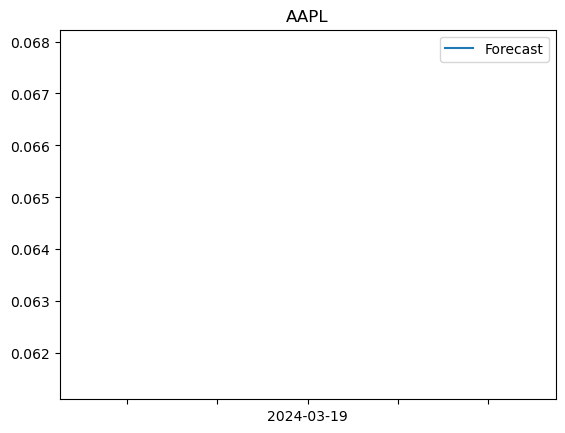

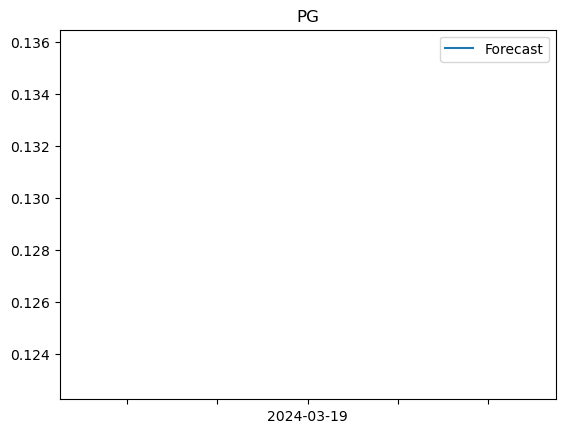

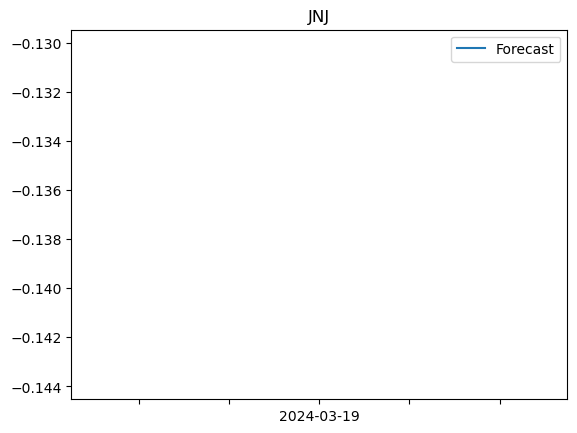

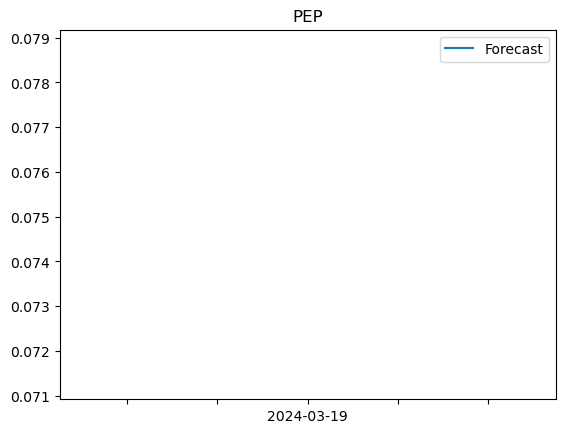

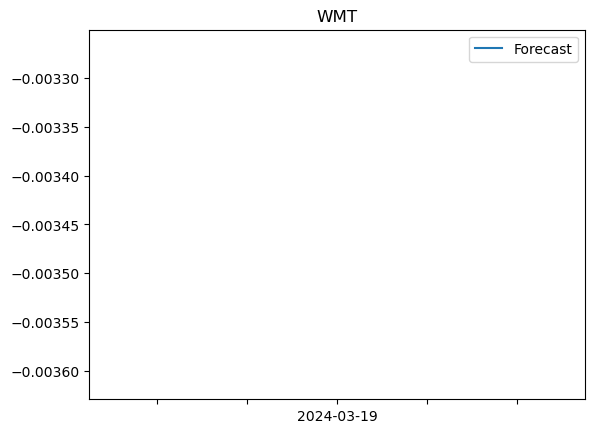

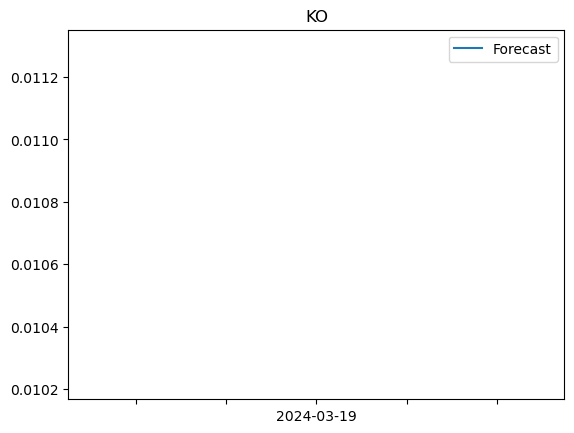

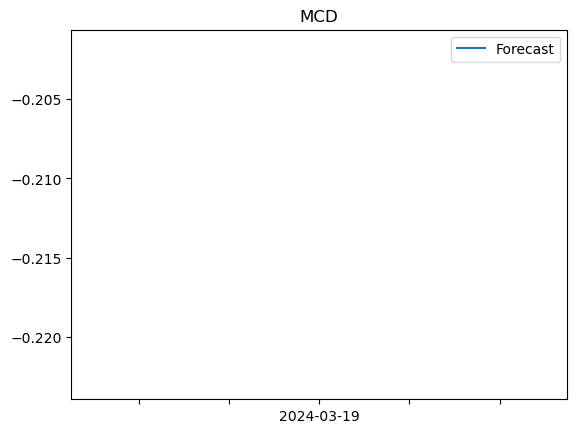

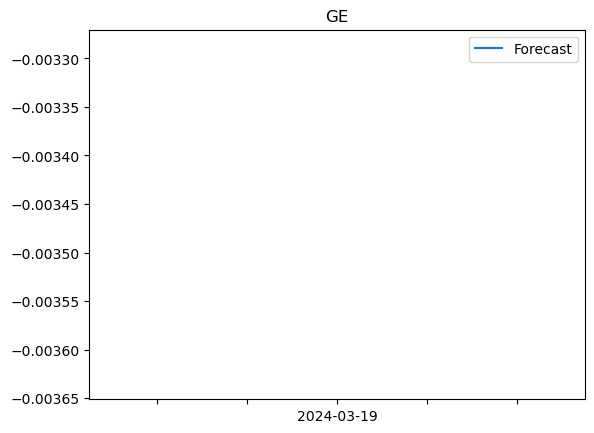

In [147]:
# To view forecasts over time for our stocks, we can plot the saved historical forecast data
for ticker in ticker_list:
    plot_historical(ticker)